# Assignment 1

That is the first group assignment for NLP course at CEU. This Assignment is based on the Titanic dataset and lecture notes of the course.

In [562]:
#Import the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import preprocessing
import os
import seaborn as sns
from plotnine import *

In [563]:
#Data set already divided in train and test, import both of them
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [564]:
#look which variables I already have
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data.

### Missing Data

We can use seaborn to visualize missing data.

<AxesSubplot:>

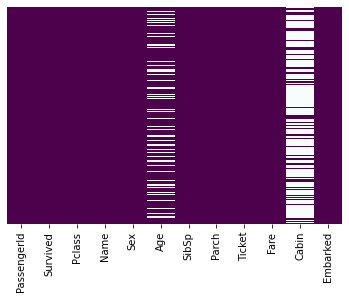

In [565]:
import seaborn as sns
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='BuPu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

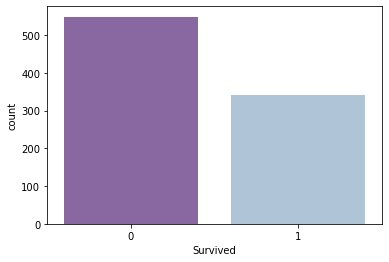

In [566]:
sns.set_style(None)
sns.countplot(x='Survived', data=train, palette='BuPu_r')

<AxesSubplot:xlabel='Sex', ylabel='count'>

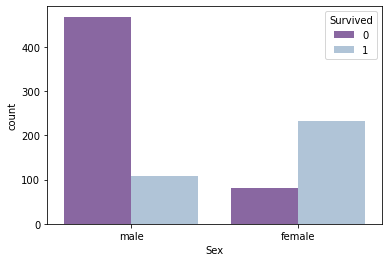

In [567]:
sns.countplot(x='Sex', hue='Survived', data=train, palette='BuPu_r')

<AxesSubplot:xlabel='Pclass', ylabel='count'>

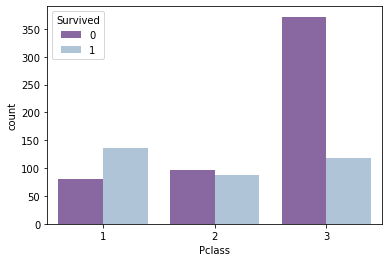

In [568]:
sns.countplot(x='Pclass', hue='Survived', data=train, palette='BuPu_r')

C:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='Age', ylabel='Density'>

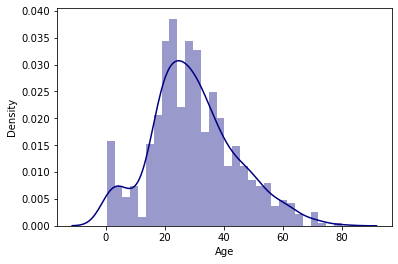

In [569]:
sns.distplot(train['Age'], color='navy', bins=30)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

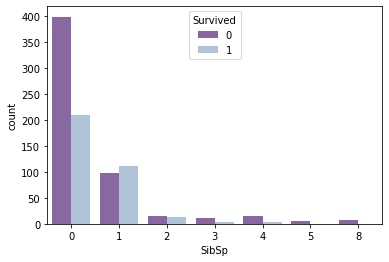

In [570]:
sns.countplot(x='SibSp', hue='Survived', data=train, palette='BuPu_r')

C:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='Fare'>

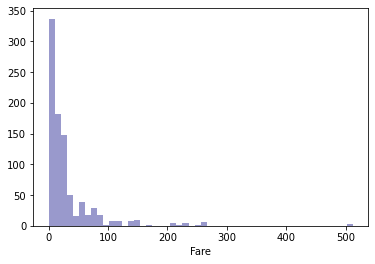

In [571]:
sns.distplot(train['Fare'], color='navy', bins=50, kde=False)

### Data Cleaning

The algorithms do not understand missing data so we need to tell the program exactly what to do with them. If we drop all missings observations, we drop a big chunk of the dataset. If we think age would be a good predictor of survival, then we should try to replace missing values.

- What are common approaches to deal with missing data?
- Make sure you know how does scikit-learn and pandas deal with missings.

Let's do a bit more explorations such as boxplots by survival category. 

<AxesSubplot:xlabel='Survived', ylabel='Age'>

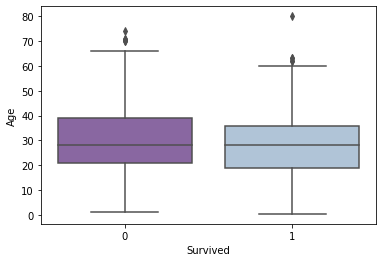

In [572]:
sns.boxplot(x='Survived', y='Age', data=train, palette='BuPu_r')

C:\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


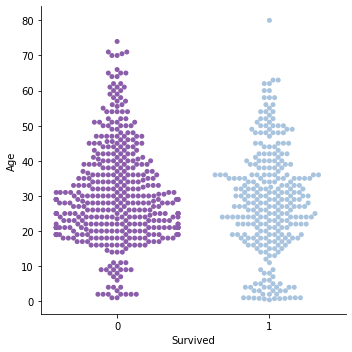

In [573]:
sns.catplot(y='Age', x='Survived', kind="swarm",  data=train,palette='BuPu_r')

C:\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


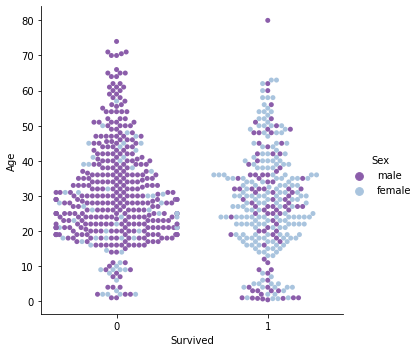

In [574]:
sns.catplot( x='Survived', y='Age', hue="Sex", kind="swarm", data=train, palette='BuPu_r')

In [575]:
#Now, let's finally replace some missing values :-)

train["Age"] = train.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))
test["Age"] = test.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))

<AxesSubplot:>

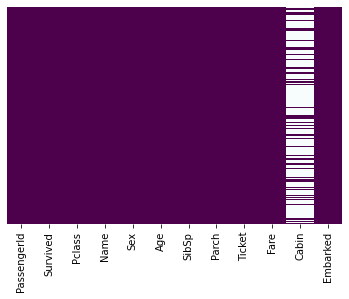

In [576]:
sns.heatmap(train.isnull(), yticklabels=False,cbar=False, cmap='BuPu_r')

<AxesSubplot:>

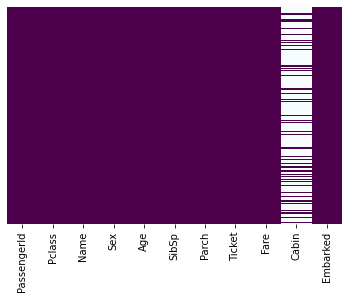

In [577]:
sns.heatmap(test.isnull(), yticklabels=False,cbar=False, cmap='BuPu_r')

I want to check test more precise for missing values, because later I found there is 1 I didn't see on heatmap. For this I will define missing value function

In [578]:
#Function to define table with missing values
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

In [579]:
missing_zero_values_table(test)

Your selected dataframe has 11 columns and 418 Rows.
There are 2 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
Cabin,0,327,78.2,327,78.2,object
Fare,2,1,0.2,3,0.7,float64


In [580]:
#I would like to replace this one missing value in fare with the mean
test.Fare.describe()

count    417.000000
mean      35.627188
std       55.907576
min        0.000000
25%        7.895800
50%       14.454200
75%       31.500000
max      512.329200
Name: Fare, dtype: float64

In [581]:
test['Fare'] = test['Fare'].fillna(value= 35.627188) 

In [582]:
train['cabin_missing'] = pd.isna(train['Cabin'])
test['cabin_missing'] = pd.isna(test['Cabin'])

# 1. Engineer at least two more features to include in your model . For each feature perform visualizations and interpret them

I decided to genereate the following features: title and variable which will describe whether person was alone or not.

# Title

Title can be extracted from the Name column. Title may be important. For example, it can provide information wether a person is married or not and as a result has a higher social status.

In [583]:
train.Name #look how this column Name looks like

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

From the example above I can see that in Name column first goes the name, after which there is a "," sign. Then I want to split every value by "," and take the second value (fist in Python). Then I use the fact that titles are separated by the dot after - I will utilize it to extact titles by splitting by "." and taking the first (zero in Python) value. And I will use strip () to remove all the the leading and trailing spaces from a string..

In [584]:
train['Title'] = train.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
test['Title'] = test.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip()) # I do feature engineering for both parts of dataset

In [585]:
train['Title']

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

In [586]:
train['Title'].describe()

count     891
unique     17
top        Mr
freq      517
Name: Title, dtype: object

In [587]:
train['Title'].unique() #check wether all titles extracted are indeed titles - looks like

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [588]:
test['Title'].unique() #check for test as well just in case some titles got missed during the split

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

<AxesSubplot:xlabel='Title', ylabel='count'>

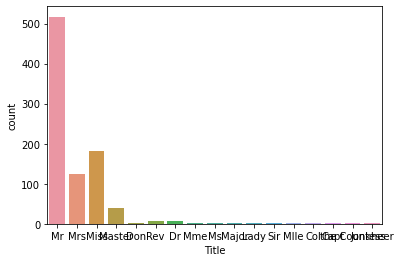

In [589]:
#Now let's look at count plot of Title column
sns.countplot(x ='Title', data=train)


As I can see, some titles are much more often to see. So, it makes sense to group some titles together. 

In [590]:
train['Title'] = train['Title'].replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')
    
# And do the same for test as well
test['Title'] = test['Title'].replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test['Title'] = test['Title'].replace('Mlle', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')

<AxesSubplot:xlabel='Title', ylabel='count'>

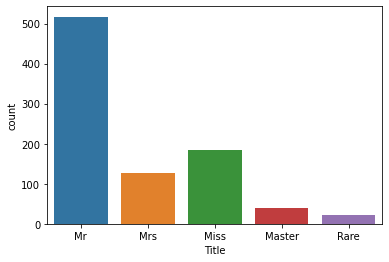

In [591]:
#Let's look at countplot again
sns.countplot(x ='Title', data=train)

As I can see, Mr is still the most common title. Rare titles even combined for a small proportion of the titles present on board

In [592]:
# I also want to look at survival rate by titles
# Survival rate by title group
train.groupby(['Title'])['Survived'].describe()

,count,mean,std,min,25%,50%,75%,max
Title,,,,,,,,
Master,40.0,0.575000,0.500641,0.0,0.0,1.0,1.0,1.0
Miss,185.0,0.702703,0.458309,0.0,0.0,1.0,1.0,1.0
Mr,517.0,0.156673,0.363844,0.0,0.0,0.0,0.0,1.0
Mrs,126.0,0.793651,0.406300,0.0,1.0,1.0,1.0,1.0
Rare,23.0,0.347826,0.486985,0.0,0.0,0.0,1.0,1.0


From the table enough I can say that titles Miss and Mrs were more likely to survive (which is not suprising since they are women). Mr has the lowest chance. And Rare titles also had a law probability to survive

# Family Size and Is Alone

Variable wether the person is alone might be important because perhaps it allowed the passenger to fastly be evacuated because he didn't need to look for his family friends or family and just proceeded to evacuation. To obtain this variable, we first need to create family size variable which is obtained from siblings + spouse variable (SibSp) and parents + children variable (Parch)

In [593]:
#Generate variable family size
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1 #i add 1 because i need to count person for whom I calculate as well
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1 #do it for test as well

<AxesSubplot:xlabel='FamilySize', ylabel='count'>

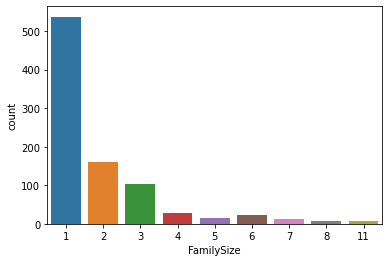

In [594]:
#let's built countplot for this variable
sns.countplot(x = 'FamilySize', data = train)

As we can, see it was most common to be alone. Then we have a high frequency of people whose family size on board is 2-3 and then for other size of family size the frequency is guite low


In [595]:
#How survival looks for different family sizes
train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


Surprisingly, among those who had a family size of 2-4 the chances to survive were higher. Perhaps it is because those families could afford to buy tickets for family members and were wealthier. Why then with number of family size of 5 and more chances of survival got lower? Perhaps 2-4 family members is also an indicator of middle and upper class. While 5 and more family size shows poorer families.

In [596]:
#Now let's create IsAlone variable if person was on Titanic without family members
train['IsAlone'] = 0
train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1
test['IsAlone'] = 0 #same for test
test.loc[train['FamilySize'] == 1, 'IsAlone'] = 1


<AxesSubplot:xlabel='IsAlone', ylabel='count'>

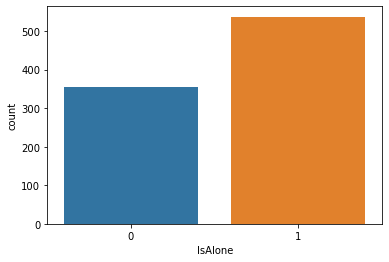

In [597]:
#Let's look at countplot
sns.countplot(x = 'IsAlone', data = train)

There are more people who were on Titanic alone

In [598]:
#Let's look at survival rate
train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


Indeed, for a person who is alone, the survival chances are higher

# 2. Can you think of possible interactions and polynomials potentially relevant for your model? If yes, do so

In [599]:
#Let's look at columns once again
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'cabin_missing',
       'Title', 'FamilySize', 'IsAlone'],
      dtype='object')

# Polinomials: age

There may be a non linear relationship between age and survival variable, so I want to include age squared

In [600]:
train['Age_sq'] = train['Age']**2
test['Age_sq'] = test['Age']**2

# Interactions

Potential interaction: class and sex (the effect of passenger class on survival may be different depending on gender of passenger)

Let's check wether this interaction assumption is valid by looking at conditional means

In [601]:
def diff_by_variables(train, factor_var, dummy_var):
    stats = train.groupby([factor_var, dummy_var]).agg(
        Mean=("Survived", np.mean), sd=("Survived", np.std), size=("Survived", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + ylab("Mean Survived")
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
        )
        + scale_fill_grey()
    )

    return plot
# definition of function is taken from Data Analysis by Gabor Bekes and Gabor Kezdi: https://github.com/gabors-data-analysis/da_case_studies

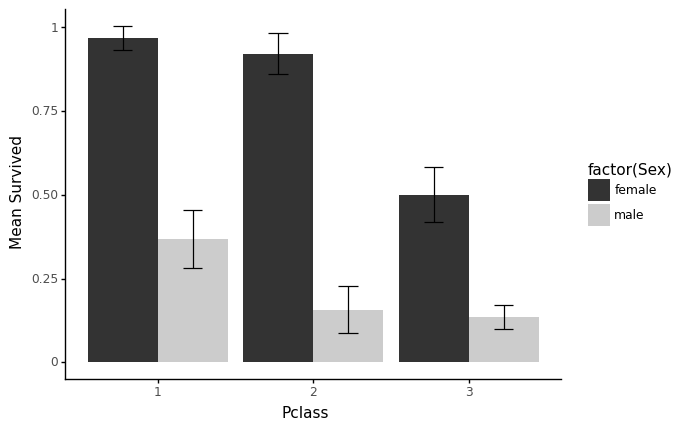

<ggplot: (158070418234)>

In [602]:
diff_by_variables(train, 'Pclass', 'Sex') #let's plot

Indeed, depending on gender, there is an evidence to suspect different effect of passenger class on survival. In every class, of the passenger is a woman, the chances of survival are much higher. I will include this interaction in my model.

In [603]:
#I will engineer this interaction after converting categorical variables


## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas. Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [604]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            891 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          204 non-null    object 
 11  Embarked       889 non-null    object 
 12  cabin_missing  891 non-null    bool   
 13  Title          891 non-null    object 
 14  FamilySize     891 non-null    int64  
 15  IsAlone        891 non-null    int64  
 16  Age_sq         891 non-null    float64
dtypes: bool(1), float64(3), int64(7), object(6)
memory usa

In [605]:
#converting into dummies
sex = pd.get_dummies(train['Sex'], drop_first=True)
embark = pd.get_dummies(train['Embarked'], drop_first=True)
pclass = pd.get_dummies(train['Pclass'], drop_first=True)
title = pd.get_dummies(train['Title'], drop_first=True)

In [606]:
train.shape

(891, 17)

In [607]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'cabin_missing',
       'Title', 'FamilySize', 'IsAlone', 'Age_sq'],
      dtype='object')

Note: drop_first=True is important to use, as it helps in reducing the extra column created during dummy variable creation. Hence it reduces the correlations created among dummy variables.
Let’s say we have 3 types of values in Categorical column and we want to create dummy variable for that column. If one variable is not furnished and semi_furnished, then It is obvious unfurnished. So we do not need 3rd variable to identify the unfurnished

In [608]:
train.drop(['Sex','Embarked','Name','Ticket', 'PassengerId', 'Pclass', 'Cabin', 'Title', 'FamilySize'], axis=1, inplace=True)

In [609]:
train = pd.concat([train, sex, embark, pclass, title], axis=1)

In [610]:
train.head()

,Survived,Age,SibSp,Parch,Fare,cabin_missing,IsAlone,Age_sq,male,Q,S,2,3,Miss,Mr,Mrs,Rare
0,0,22.0,1,0,7.2500,True,0,484.0,1,0,1,0,1,0,1,0,0
1,1,38.0,1,0,71.2833,False,0,1444.0,0,0,0,0,0,0,0,1,0
2,1,26.0,0,0,7.9250,True,1,676.0,0,0,1,0,1,1,0,0,0
3,1,35.0,1,0,53.1000,False,0,1225.0,0,0,1,0,0,0,0,1,0
4,0,35.0,0,0,8.0500,True,1,1225.0,1,0,1,0,1,0,1,0,0


In [611]:
train.columns

Index([     'Survived',           'Age',         'SibSp',         'Parch',
                'Fare', 'cabin_missing',       'IsAlone',        'Age_sq',
                'male',             'Q',             'S',               2,
                     3,          'Miss',            'Mr',           'Mrs',
                'Rare'],
      dtype='object')

In [612]:
#Now I creaate an interaction I suggested before
train['male_2'] = train['male'] * train[2]
train['male_3'] = train['male'] * train[3]

In [613]:
train.head()

,Survived,Age,SibSp,Parch,Fare,cabin_missing,IsAlone,Age_sq,male,Q,S,2,3,Miss,Mr,Mrs,Rare,male_2,male_3
0,0,22.0,1,0,7.2500,True,0,484.0,1,0,1,0,1,0,1,0,0,0,1
1,1,38.0,1,0,71.2833,False,0,1444.0,0,0,0,0,0,0,0,1,0,0,0
2,1,26.0,0,0,7.9250,True,1,676.0,0,0,1,0,1,1,0,0,0,0,0
3,1,35.0,1,0,53.1000,False,0,1225.0,0,0,1,0,0,0,0,1,0,0,0
4,0,35.0,0,0,8.0500,True,1,1225.0,1,0,1,0,1,0,1,0,0,0,1


In [614]:
test.info() #right, in test there is 1 variable less (survival, we need to predict it)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    418 non-null    int64  
 1   Pclass         418 non-null    int64  
 2   Name           418 non-null    object 
 3   Sex            418 non-null    object 
 4   Age            418 non-null    float64
 5   SibSp          418 non-null    int64  
 6   Parch          418 non-null    int64  
 7   Ticket         418 non-null    object 
 8   Fare           418 non-null    float64
 9   Cabin          91 non-null     object 
 10  Embarked       418 non-null    object 
 11  cabin_missing  418 non-null    bool   
 12  Title          418 non-null    object 
 13  FamilySize     418 non-null    int64  
 14  IsAlone        418 non-null    int64  
 15  Age_sq         418 non-null    float64
dtypes: bool(1), float64(3), int64(6), object(6)
memory usage: 49.5+ KB


In [615]:
#And now just do the same convertion for test
sex = pd.get_dummies(test['Sex'], drop_first=True)
embark = pd.get_dummies(test['Embarked'], drop_first=True)
pclass = pd.get_dummies(test['Pclass'], drop_first=True)
title = pd.get_dummies(test['Title'], drop_first=True)

In [616]:
test.drop(['Sex','Embarked','Name','Ticket', 'PassengerId', 'Pclass', 'Cabin', 'Title', 'FamilySize'], axis=1, inplace=True)

In [617]:
test = pd.concat([test, sex, embark, pclass, title], axis=1)

In [618]:
test['male_2'] = test['male'] * test[2]
test['male_3'] = test['male'] * test[3]

In [619]:
test.head()

,Age,SibSp,Parch,Fare,cabin_missing,IsAlone,Age_sq,male,Q,S,2,3,Miss,Mr,Mrs,Rare,male_2,male_3
0,34.5,0,0,7.8292,True,0,1190.25,1,1,0,0,1,0,1,0,0,0,1
1,47.0,1,0,7.0000,True,0,2209.00,0,0,1,0,1,0,0,1,0,0,0
2,62.0,0,0,9.6875,True,1,3844.00,1,1,0,1,0,0,1,0,0,1,0
3,27.0,0,0,8.6625,True,0,729.00,1,0,1,0,1,0,1,0,0,0,1
4,22.0,1,1,12.2875,True,1,484.00,0,0,1,0,1,0,0,1,0,0,0


# Prediction

# 3. Include the new features --generated in 1 and  2 -- in your model. Does your model improve? What measures did you use to determine this? Interpret coefficients. Do the signs of the coefficients make sense? Why and why not? 

Let's evaluate our model with these new features engineered

In [640]:
X = train.drop('Survived',axis=1)
y = train['Survived']
seed = 12

In [641]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = seed, stratify=y)

In [642]:
from sklearn.linear_model import LogisticRegression

In [643]:
logreg = LogisticRegression()
from sklearn import preprocessing
X_train = preprocessing.scale(X_train)

In [644]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [645]:
from sklearn import *

In [646]:
X_test = preprocessing.scale(X_test)
predictions = logreg.predict(X_test)

In [647]:
predictions

array([0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1], dtype=int64)

### Model Evaluation

In [648]:
from sklearn.metrics import classification_report, confusion_matrix

In [649]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       137
           1       0.78      0.76      0.77        86

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.82      0.83      0.82       223

